This notebooks runs model experiments using the Catboost and TabPFN model architectures which benefit from GPU computation.

In [ ]:
import os
import psutil
import sys
from pathlib import Path

In [ ]:
# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
		# Install required packages
    !pip install -q pandas numpy matplotlib seaborn sklearn tabpfn tabpfn-extensions
    
    # Download required files from GCS
    project = 'fwi-water-quality-sensing'
    bucket_name = 'fwi-predict'
    local_predict_df_path = '/tmp/predict_df.csv'
    local_sentinel_path = '/tmp/sentinel2.csv'
    
    !gcloud config set project {project}
    !gsutil cp gs://{bucket_name}/train/predict_dfs/jun_21_dec_24_w_metadata_predict_df.csv {local_predict_df_path}
    !gsutil cp gs://{bucket_name}/train/sentinel2/jun_21_dec_24_w_metadata.csv {local_sentinel_path}
else:
    data_dir = Path('../../data')
    local_predict_df_path = data_dir / "predict_dfs/train/jun_21_dec_24_w_metadata_predict_df.csv"
    local_sentinel_path = data_dir / "gcs/train/sentinel2/jun_21_dec_24_w_metadata.csv"


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
# Load and merge
predict_df = pd.read_csv(local_predict_df_path, parse_dates=['sample_dt'], index_col=0)
sentinel_features = pd.read_csv(local_sentinel_path).drop(columns=['system:index', '.geo'])
predict_df = predict_df.merge(sentinel_features, on='sample_idx')

# Drop unhelpful features
num_sum_cols = predict_df.columns[predict_df.columns.str.contains('num_sum')].tolist()
drop_cols = ['sample_idx', 'geometry', 'sample_dt', 'prev_sample_dt'] + num_sum_cols
predict_df = predict_df.drop(columns=drop_cols)

# Get parameters for classification problem
# predict_df['month'] = predict_df['sample_dt'].dt.month # Not including for now since last year had odd trend I don't want attributed to month

predict_df = predict_df.drop(columns=['ammonia_mg_per_L', 'ph', 'turbidity_cm'])
winkler_df = predict_df[predict_df['do_winkler']].copy()       

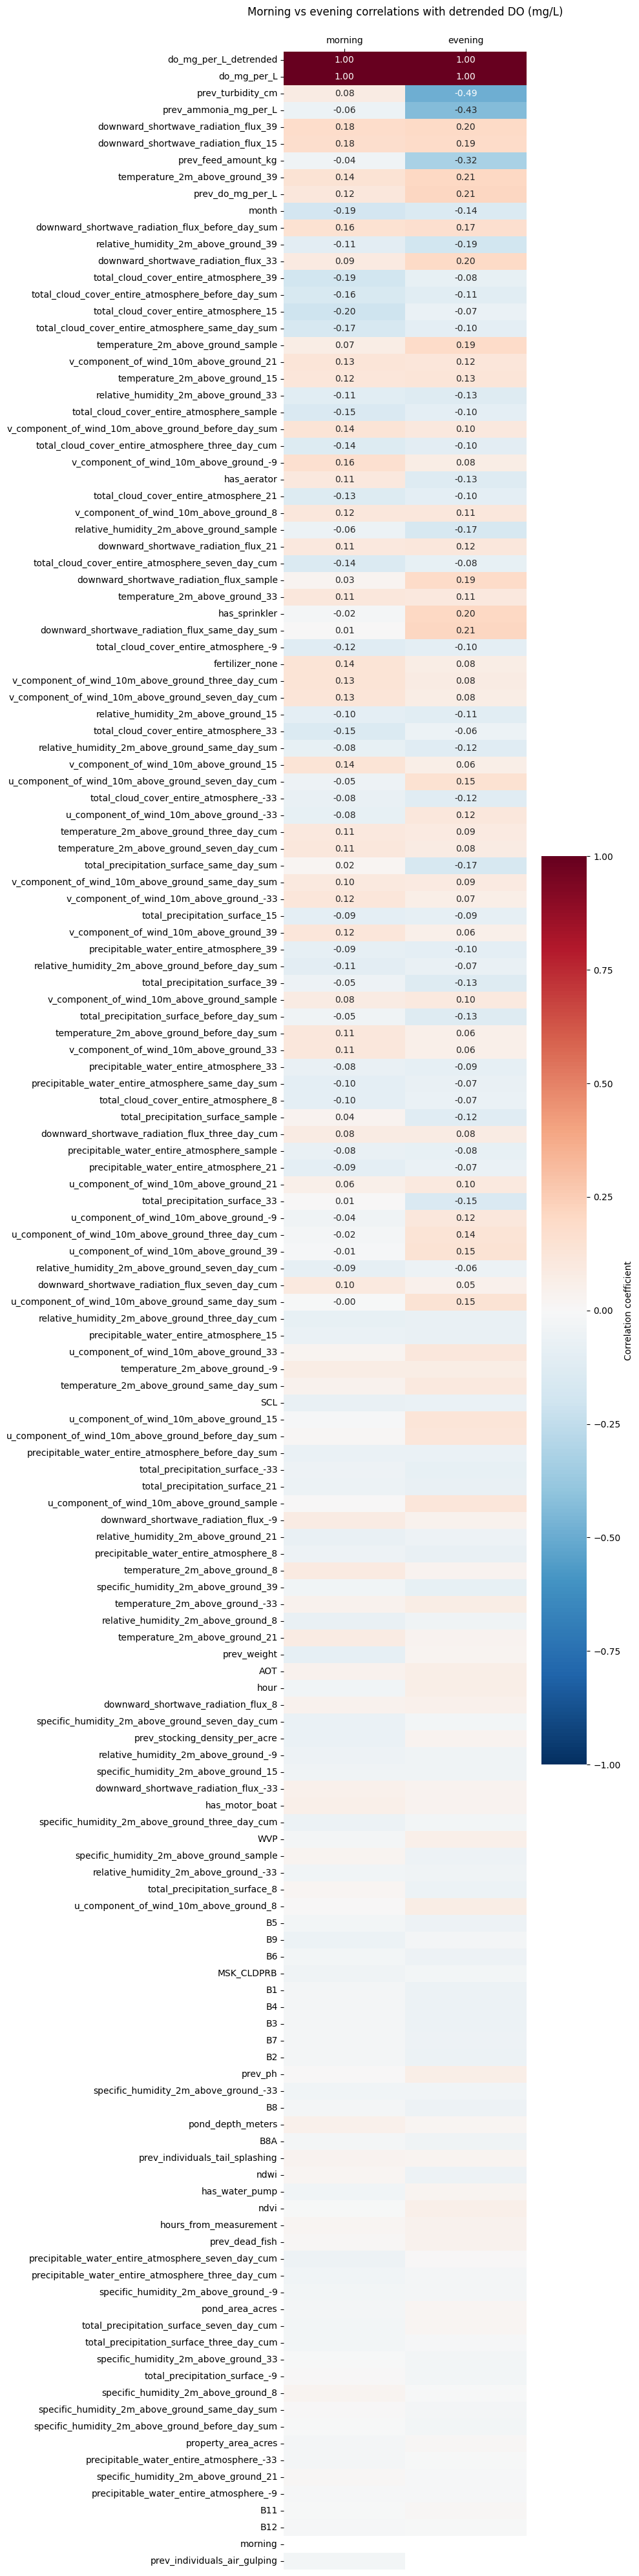

In [ ]:
# Create copy of winkler_df and group by morning to detrend DO values
winkler_df = winkler_df.copy()
diurnal_means = winkler_df.groupby(['morning'])['do_mg_per_L'].transform('mean')
winkler_df['do_mg_per_L_detrended'] = winkler_df['do_mg_per_L'] - diurnal_means

# Calculate correlations separately for morning and evening
numeric_cols = winkler_df.select_dtypes(include=['float64', 'int64', 'bool']).columns.drop(['do_winkler'])

morning_corr = winkler_df[winkler_df['morning']][numeric_cols].corr()['do_mg_per_L_detrended']
evening_corr = winkler_df[~winkler_df['morning']][numeric_cols].corr()['do_mg_per_L_detrended']

# Combine correlations into a DataFrame
corr_comparison = pd.DataFrame({
    'morning': morning_corr,
    'evening': evening_corr
})
corr_comparison['total'] = corr_comparison['morning'].abs() + corr_comparison['evening'].abs()
corr_comparison = corr_comparison.sort_values('total', ascending=False).drop('total', axis=1)

# Create heatmap
plt.figure(figsize=(10, 40))
sns.heatmap(corr_comparison,
            vmin=-1,
            vmax=1,
            cmap='RdBu_r',
            center=0,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Correlation coefficient'})
plt.title('Morning vs evening correlations with detrended DO (mg/L)', pad=40)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.tight_layout()
plt.show()

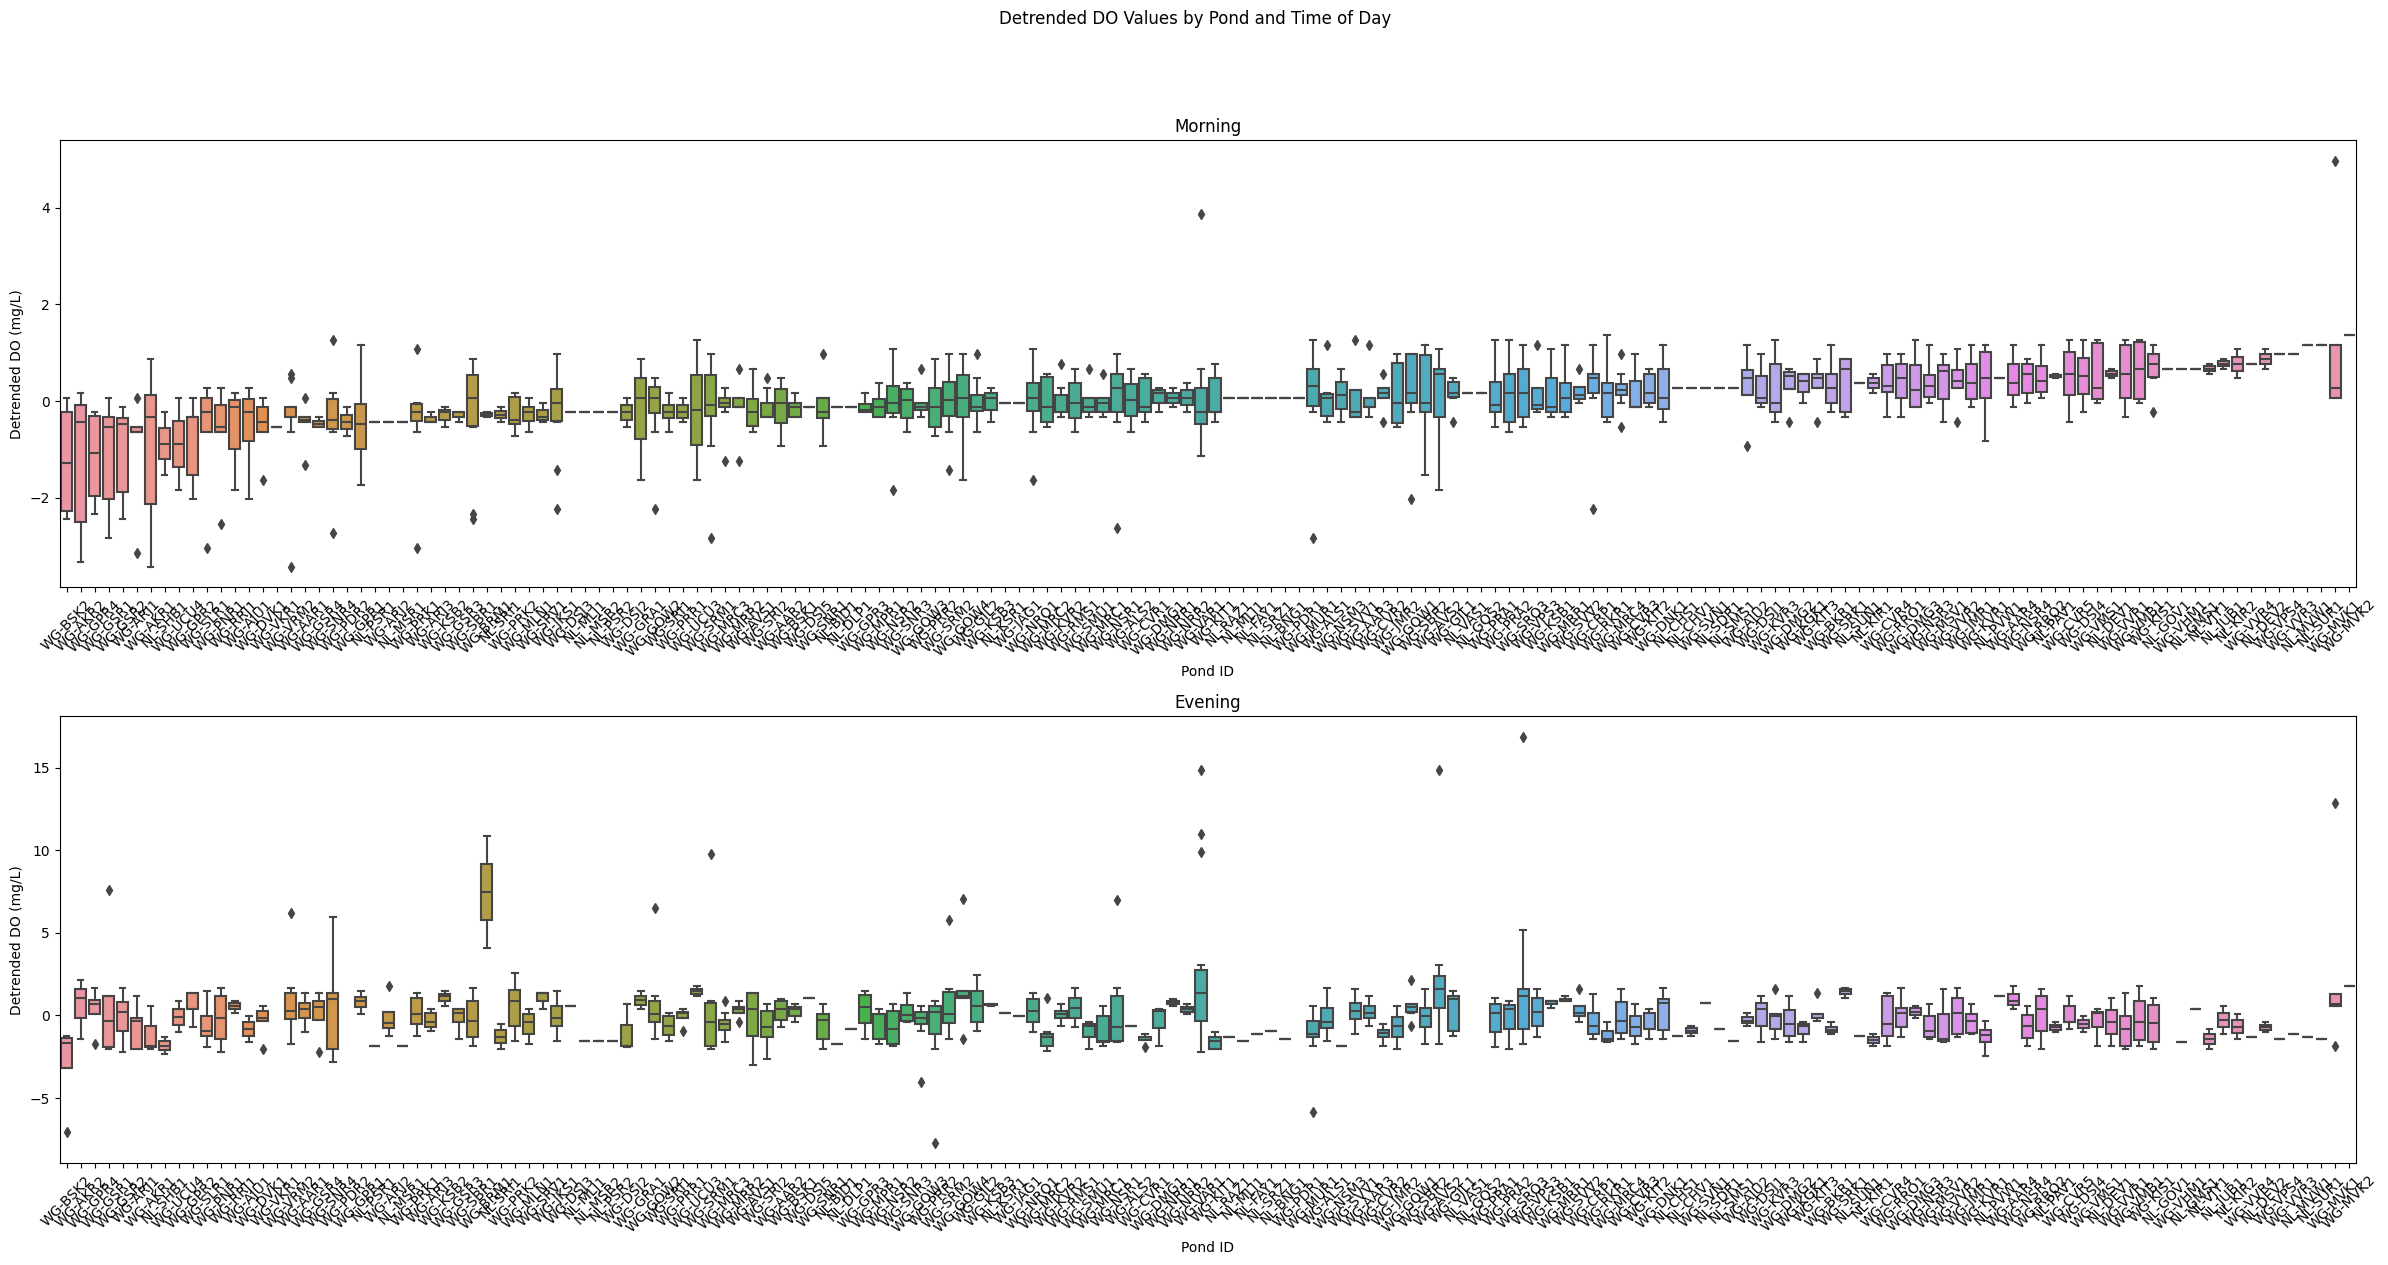

In [ ]:
# Calculate morning means to sort ponds
morning_means = winkler_df[winkler_df['morning']].groupby('pond_id')['do_mg_per_L_detrended'].mean()
pond_order = morning_means.sort_values().index

# Create separate plots for morning and evening
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 12))

# Morning plot
morning_data = winkler_df[winkler_df['morning']]
sns.boxplot(data=morning_data, x='pond_id',
            y='do_mg_per_L_detrended', order=pond_order, ax=ax1)
ax1.set_title('Morning')
ax1.set_xlabel('Pond ID')
ax1.set_ylabel('Detrended DO (mg/L)')
ax1.tick_params(axis='x', rotation=45)

# Evening plot  
evening_data = winkler_df[~winkler_df['morning']]
sns.boxplot(data=evening_data, x='pond_id',
            y='do_mg_per_L_detrended', order=pond_order, ax=ax2)
ax2.set_title('Evening')
ax2.set_xlabel('Pond ID')
ax2.set_ylabel('Detrended DO (mg/L)')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Detrended DO Values by Pond and Time of Day', y=1.05)
plt.tight_layout()
plt.show()

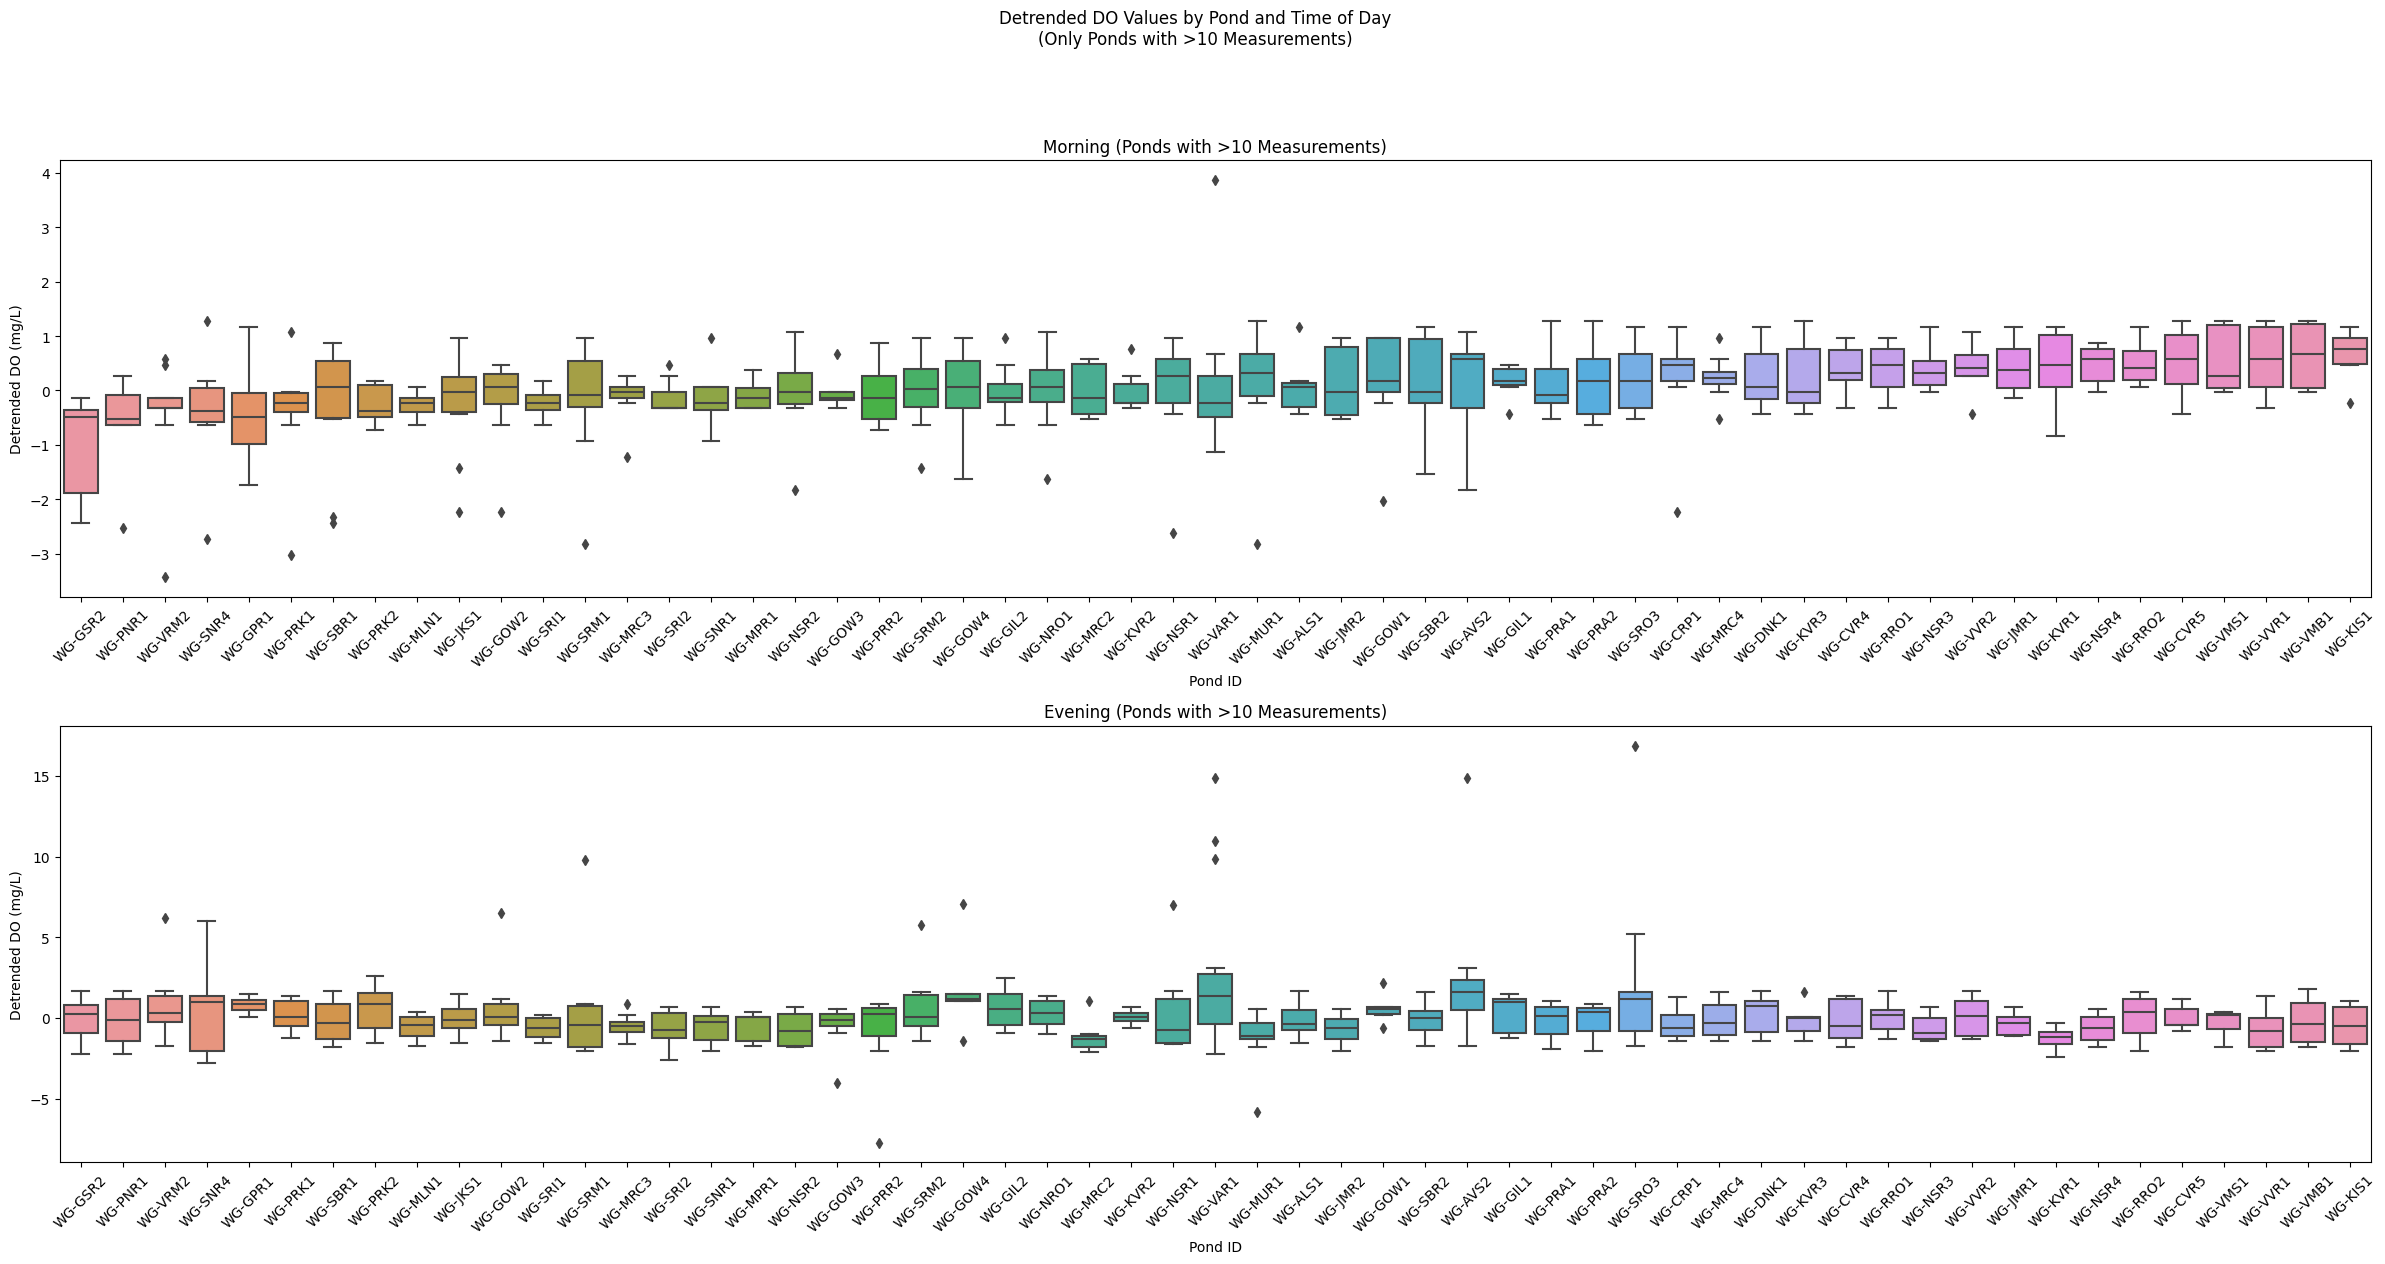

In [ ]:
# Get ponds with more than 10 measurements
pond_counts = winkler_df.groupby('pond_id').size()
valid_ponds = pond_counts[pond_counts > 10].index

# Filter data for valid ponds
winkler_df_filtered = winkler_df[winkler_df['pond_id'].isin(valid_ponds)]

# Calculate morning means to sort ponds
morning_means = winkler_df_filtered[winkler_df_filtered['morning']].groupby('pond_id')['do_mg_per_L_detrended'].mean()
pond_order = morning_means.sort_values().index

# Create separate plots for morning and evening
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 12))

# Morning plot
morning_data = winkler_df_filtered[winkler_df_filtered['morning']]
sns.boxplot(data=morning_data, x='pond_id',
            y='do_mg_per_L_detrended', order=pond_order, ax=ax1)
ax1.set_title('Morning (Ponds with >10 Measurements)')
ax1.set_xlabel('Pond ID')
ax1.set_ylabel('Detrended DO (mg/L)')
ax1.tick_params(axis='x', rotation=45)

# Evening plot  
evening_data = winkler_df_filtered[~winkler_df_filtered['morning']]
sns.boxplot(data=evening_data, x='pond_id',
            y='do_mg_per_L_detrended', order=pond_order, ax=ax2)
ax2.set_title('Evening (Ponds with >10 Measurements)')
ax2.set_xlabel('Pond ID')
ax2.set_ylabel('Detrended DO (mg/L)')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Detrended DO Values by Pond and Time of Day\n(Only Ponds with >10 Measurements)', y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
categoricals = ['farm', 'region', 'month', 'pond_id', 'village', 'SCL']
non_categoricals = winkler_df.columns[~winkler_df.columns.isin(categoricals)].tolist()

In [ ]:
# Calculate correlations separately for morning and evening
morning_data = winkler_df[winkler_df['morning']]
evening_data = winkler_df[~winkler_df['morning']]

# Calculate correlations for morning data
morning_corr = morning_data[non_categoricals].corr()['do_mg_per_L_detrended'].abs()
morning_high_corr = morning_corr[morning_corr > 0.17].index.tolist()

# Calculate correlations for evening data  
evening_corr = evening_data[non_categoricals].corr()['do_mg_per_L_detrended'].abs()
evening_high_corr = evening_corr[evening_corr > 0.17].index.tolist()

# Combine features that are important for either morning or evening
high_corr_features = list(set(morning_high_corr + evening_high_corr))

# Remove target variables from features list
high_corr_features = [col for col in high_corr_features if col not in ['do_mg_per_L', 'do_mg_per_L_detrended']]

print("Number of high correlation features:", len(high_corr_features))


Number of high correlation features: 16


In [ ]:
experiment_df = winkler_df.drop(columns=['do_mg_per_L_detrended']).copy()

In [ ]:
# Feature categories
base_weather_forecast_features = experiment_df.columns[experiment_df.columns.str.contains('downward_shortwave|precipitable|relative_hum|specific_hum|temperature_2m|total_cloud|total_precip')].tolist()
ext_weather_forecast_features = base_weather_forecast_features + experiment_df.columns[experiment_df.columns.str.contains('u_component|v_component')].tolist()
satellite_features = ['AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'MSK_CLDPRB', 'SCL', 'WVP', 'hours_from_measurement', 'ndvi','ndwi']
lag_features = experiment_df.columns[experiment_df.columns.str.startswith('prev_')].tolist()
pond_features = (
  experiment_df.columns[experiment_df.columns.str.startswith('fertilizer_|feed_|has_')].tolist() + ['pond_area_acres', 'property_area_acres', 'pond_depth_meters', 'pond_preparation']
)

# Feature sets
base_feature_set = ['morning', 'region', 'hour'] + base_weather_forecast_features
ext_weather_forecast_set = base_feature_set + ext_weather_forecast_features

# Add categoricals
base_w_categoricals = list(set(base_feature_set + categoricals))
base_w_lag_features = base_feature_set + lag_features
base_w_satellite_features = base_feature_set + satellite_features
base_w_pond_features = base_feature_set + pond_features
high_corr_set = high_corr_features + ['morning', 'region']

In [ ]:
if IN_COLAB:
		# Make sure reflects latest versions in local repository
		WQ_RANGES = {
				'do_mg_per_L': {
						'required': {
								'morning': (3, 5),
								'evening': (8, 12)
						},
						'ideal': {
								'morning': (4, 5),
								'evening': (8, 10)
						}
				},
				'ph': {
						'required': (6.5, 8.5),
						'ideal': (7, 8)
				},
				'ammonia_mg_per_L': {
						'required': (0, 0.5),
						'ideal': (0, 0.15)
				},
				'turbidity_cm': {
						'required': (20, 50),
						'ideal': (30, 40)
				}
		}
  
		def get_in_required_range(parameter: str, values, periods=None):
				"""Checks if water quality parameter is below, within, or above the required range.

				Parameters:
						parameter (str): The water quality parameter to check (e.g., 'do', 'ph', 'ammonia', 'turbidity').
						values: Array-like of measurement values (numpy array or pandas Series).
						periods: Array-like of periods ('morning', 'evening', etc.), required for period-dependent parameters.

				Returns:
						Array-like: Array of strings indicating if values are 'below', 'within', or 'above' the required range.
				"""
				# Convert inputs to numpy arrays for consistent handling
				values = np.asarray(values)
				
				# Ensure the parameter is valid
				if parameter not in WQ_RANGES:
						raise ValueError(f"Invalid parameter: {parameter}. Must be one of {list(WQ_RANGES.keys())}.")
				
				required_ranges = WQ_RANGES[parameter]['required']
				
				# Handle case where ranges are split by periods
				if isinstance(required_ranges, dict):
						if periods is None:
								raise ValueError(f"Periods must be provided for parameter {parameter}")
								
						periods = np.asarray(periods)
						result = np.full(values.shape, '', dtype='U6') # Initialize output array

						# Process each period
						for period, (low, high) in required_ranges.items():
								mask = periods == period
								conditions = [values[mask] < low, (values[mask] >= low) & (values[mask] <= high), values[mask] > high]
								result[mask] = np.select(conditions, ['below', 'within', 'above'], default='')
								
						return result
				
				# Handle case where ranges are not split by periods
				low, high = required_ranges
				conditions = [values < low, (values >= low) & (values <= high), values > high]
				return np.select(conditions, ['below', 'within', 'above'], default='')
		
else:
		from fwi_predict.constants import WQ_RANGES
		from fwi_predict.wq import get_in_required_range

In [ ]:
# Import necessary libraries
from typing import List, Dict, Tuple

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import root_mean_squared_error, precision_score, recall_score, r2_score
from sklearn.model_selection import cross_val_predict, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, TargetEncoder

In [ ]:
# Define diurnal detrend transform
class DiurnalDetrend(BaseEstimator, TransformerMixin):
    """Detrend data by subtracting morning/evening means."""
    def fit(self, X, y=None):
        # Calculate means for morning/evening
        df = pd.DataFrame({'y': y, 'morning': X['morning']})
        self.morning_mean_ = df[df['morning']]['y'].mean()
        self.evening_mean_ = df[~df['morning']]['y'].mean()
        return self

    def transform(self, X, y=None):
        if y is not None:
            y_detrended = y.copy()
            y_detrended[X['morning']] -= self.morning_mean_
            y_detrended[~X['morning']] -= self.evening_mean_
            return y_detrended
        return X
    
    def inverse_transform(self, X, y):
        y_retrended = y.copy()
        y_retrended[X['morning']] += self.morning_mean_
        y_retrended[~X['morning']] += self.evening_mean_
        return y_retrended

In [ ]:
workers = psutil.cpu_count() if IN_COLAB else psutil.cpu_count(logical=False) - 1
print(f"Workers: {workers}")

Workers: 9


In [ ]:
def evaluate_predictions(y_true, y_pred, morning_series):
    """Evaluate model performance including DO range classification."""
    # Get range classifications
    time_of_day = morning_series.apply(lambda x: 'morning' if x else 'evening')
    true_ranges = get_in_required_range('do_mg_per_L', y_true, time_of_day)
    pred_ranges = get_in_required_range('do_mg_per_L', y_pred, time_of_day)
    
    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    range_accuracy = (true_ranges == pred_ranges).mean()
    
    return {
        'r2_score': r2,
        'range_accuracy': range_accuracy,
        'y_true': y_true,
        'y_pred': y_pred,
        'true_ranges': true_ranges,
        'pred_ranges': pred_ranges
    }



def run_experiment(df: pd.DataFrame, 
                  feature_set: List[str],
                  categoricals: List[str],
                  feature_selection: bool = False,
                  scoring: str = 'neg_root_mean_squared_error',
                  workers: int = workers) -> Dict:
    """Run modeling experiment with given feature set."""
    
    # Prepare data
    X = df[feature_set]
    y = df['do_mg_per_L']
    
    # Create preprocessing steps
    numeric_features = [col for col in feature_set if col not in categoricals]
    categorical_features = [col for col in feature_set if col in categoricals]
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', TargetEncoder(), categorical_features)
        ]
    )
    
    # Create pipeline
    steps = [
        ('detrend', DiurnalDetrend()),
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
    ]
    
    if feature_selection:
        steps.append(('feature_selection', 
                     RFECV(RandomForestRegressor(random_state=42),
                           cv=5,
                           scoring=scoring,
                           n_jobs=workers)))

    steps.append(('regressor', RandomForestRegressor(random_state=42)))
    
    pipeline = Pipeline(steps)
    
    # Define parameter grid
    param_grid = {
        'regressor__n_estimators': [100, 150, 250],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [5, 10],
        'regressor__min_samples_leaf': [5, 8, 10]
    }
    
    # Perform grid search
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=workers,
        verbose=1
    )
    
    # Fit model
    grid_search.fit(X, y)
    
    # Get feature importance rankings from RFECV if feature selection was used
    if feature_selection:
        feature_selector = grid_search.best_estimator_.named_steps['feature_selection']
        feature_names = numeric_features + categorical_features
        
        # Create ranking vs RMSE plot
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(feature_selector.grid_scores_) + 1), 
                np.sqrt(-feature_selector.grid_scores_), 
                marker='o')
        plt.xlabel('Number of features selected')
        plt.ylabel('Cross-validation RMSE')
        plt.title('Feature selection: Number of features vs RMSE')
        plt.grid(True)
        plt.show()
        
        # Create feature ranking plot
        ranking_df = pd.DataFrame({
            'Feature': feature_names,
            'Ranking': feature_selector.ranking_
        }).sort_values('Ranking')
        
        plt.figure(figsize=(12, 6))
        sns.barplot(data=ranking_df, x='Ranking', y='Feature')
        plt.title('Feature rankings from recursive feature elimination')
        plt.xlabel('Ranking (1 = selected)')
        plt.tight_layout()
        plt.show()
    
    # Get cross-validation predictions
    cv_predictions = cross_val_predict(
        grid_search.best_estimator_,
        X, y,
        cv=cv
    )
    
    # Evaluate performance
    results = evaluate_predictions(y, cv_predictions, df['morning'])
    
    # Plot hyperparameter effects
    cv_results = pd.DataFrame(grid_search.cv_results_)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    sns.boxplot(data=cv_results, x='param_regressor__n_estimators', y='mean_test_score', ax=ax1)
    ax1.set_title('Effect of n_estimators')
    ax1.set_ylabel('Mean CV Score (R²)')
    
    sns.boxplot(data=cv_results, x='param_regressor__max_depth', y='mean_test_score', ax=ax2)
    ax2.set_title('Effect of max_depth')
    ax2.set_ylabel('Mean CV Score (R²)')
    
    sns.boxplot(data=cv_results, x='param_regressor__min_samples_split', y='mean_test_score', ax=ax3)
    ax3.set_title('Effect of min_samples_split')
    ax3.set_ylabel('Mean CV Score (R²)')
    
    sns.boxplot(data=cv_results, x='param_regressor__min_samples_leaf', y='mean_test_score', ax=ax4)
    ax4.set_title('Effect of min_samples_leaf')
    ax4.set_ylabel('Mean CV Score (R²)')
    
    plt.tight_layout()
    plt.show()
    
    # Plot cross-validation fold performance
    cv_fold_scores = []
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X)):
        y_true_fold = y.iloc[test_idx]
        y_pred_fold = cv_predictions[test_idx]
        morning_fold = df['morning'].iloc[test_idx]
        
        # Calculate metrics for morning and evening
        morning_mask = morning_fold
        evening_mask = ~morning_fold
        
        # Calculate RMSE
        morning_rmse = root_mean_squared_error(y_true_fold[morning_mask], y_pred_fold[morning_mask])
        evening_rmse = root_mean_squared_error(y_true_fold[evening_mask], y_pred_fold[evening_mask])
        
        # Calculate classification metrics using WQ ranges
        morning_true = get_in_required_range('do_mg_per_L', y_true_fold[morning_mask], ['morning']*sum(morning_mask))
        morning_pred = get_in_required_range('do_mg_per_L', y_pred_fold[morning_mask], ['morning']*sum(morning_mask))
        evening_true = get_in_required_range('do_mg_per_L', y_true_fold[evening_mask], ['evening']*sum(evening_mask))
        evening_pred = get_in_required_range('do_mg_per_L', y_pred_fold[evening_mask], ['evening']*sum(evening_mask))
        
        # Calculate per-class metrics for morning
        for class_name in ['below', 'within', 'above']:
            morning_precision = precision_score(morning_true == class_name, morning_pred == class_name)
            morning_recall = recall_score(morning_true == class_name, morning_pred == class_name)
            
            cv_fold_scores.append({
                'fold': fold_idx + 1,
                'period': 'Morning',
                'class': class_name,
                'Precision': morning_precision,
                'Recall': morning_recall,
                'RMSE': morning_rmse
            })
            
        # Calculate per-class metrics for evening    
        for class_name in ['below', 'within', 'above']:
            evening_precision = precision_score(evening_true == class_name, evening_pred == class_name)
            evening_recall = recall_score(evening_true == class_name, evening_pred == class_name)
            
            cv_fold_scores.append({
                'fold': fold_idx + 1,
                'period': 'Evening',
                'class': class_name,
                'Precision': evening_precision,
                'Recall': evening_recall,
                'RMSE': evening_rmse
            })
    
    cv_scores_df = pd.DataFrame(cv_fold_scores)
    
    # Plot fold performance comparisons
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    sns.scatterplot(data=cv_scores_df, x='class', y='Precision', hue='period', ax=ax1)
    ax1.set_title('Precision scores by class across folds')
    
    sns.scatterlot(data=cv_scores_df, x='class', y='Recall', hue='period', ax=ax2)
    ax2.set_title('Recall scores by class across folds')
    
    # For RMSE, we need to deduplicate since it's repeated for each class
    rmse_df = cv_scores_df.drop_duplicates(['fold', 'period', 'RMSE'])
    sns.scatterplot(data=rmse_df, x='period', y='RMSE', ax=ax3)
    ax3.set_title('RMSE across folds')
    
    plt.tight_layout()
    plt.show()
    
    # Plot predictions vs actuals
    plt.figure(figsize=(15, 5))
    
    # Morning predictions
    plt.subplot(1, 2, 1)
    morning_mask = df['morning']
    plt.scatter(results['y_true'][morning_mask], 
                results['y_pred'][morning_mask], alpha=0.5)
    plt.plot([results['y_true'][morning_mask].min(), 
              results['y_true'][morning_mask].max()],
             [results['y_true'][morning_mask].min(), 
              results['y_true'][morning_mask].max()], 
             'r--', lw=2, label='Perfect prediction')
    
    # Add trend line
    z = np.polyfit(results['y_true'][morning_mask], results['y_pred'][morning_mask], 1)
    p = np.poly1d(z)
    plt.plot([results['y_true'][morning_mask].min(), 
              results['y_true'][morning_mask].max()],
             [p(results['y_true'][morning_mask].min()), 
              p(results['y_true'][morning_mask].max())],
             'g--', lw=2, label='Trend line')
    plt.legend()
    plt.xlabel('Actual DO (mg/L)')
    plt.ylabel('Predicted DO (mg/L)')
    plt.title('Morning: Predicted vs actual DO levels')
    
    # Evening predictions
    plt.subplot(1, 2, 2)
    evening_mask = ~df['morning']
    plt.scatter(results['y_true'][evening_mask],
                results['y_pred'][evening_mask], alpha=0.5)
    plt.plot([results['y_true'][evening_mask].min(),
              results['y_true'][evening_mask].max()],
             [results['y_true'][evening_mask].min(),
              results['y_true'][evening_mask].max()],
             'r--', lw=2, label='Perfect prediction')
    
    # Add trend line
    z = np.polyfit(results['y_true'][evening_mask], results['y_pred'][evening_mask], 1)
    p = np.poly1d(z)
    plt.plot([results['y_true'][evening_mask].min(),
              results['y_true'][evening_mask].max()],
             [p(results['y_true'][evening_mask].min()),
              p(results['y_true'][evening_mask].max())],
             'g--', lw=2, label='Trend line')
    plt.legend()
    plt.xlabel('Actual DO (mg/L)')
    plt.ylabel('Predicted DO (mg/L)')
    plt.title('Evening: Predicted vs actual DO levels')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_estimator': grid_search.best_estimator_,
        'results': results
    }